# Importing libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
import pickle as pkl
import numpy as np

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Input, Dense,Embedding
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import model_from_json

# Loading the data

In [3]:
with open('mar.txt','r', encoding='utf-8') as f:
  data = f.read()

len(data)

5546576

# Cleaning and preprocessing the data

In [4]:
# we need to clean the data
uncleaned_data_list = data.split('\n')

In [5]:
len(uncleaned_data_list)

41029

In [6]:
uncleaned_data_list = uncleaned_data_list[:38695]

In [7]:
len(uncleaned_data_list)

38695

In [8]:
english_word = []
marathi_word = []
cleaned_data_list = []
for word in uncleaned_data_list:
  english_word.append(word.split('\t')[:-1][0])
  marathi_word.append(word.split('\t')[:-1][1])

In [9]:
len(english_word), len(marathi_word)

(38695, 38695)

# Creating the dataframe and saving the data into csv

In [10]:
language_data = pd.DataFrame(columns=['English','Marathi'])
language_data['English'] = english_word
language_data['Marathi'] = marathi_word

In [11]:
# saving to csv
language_data.to_csv('language_data.csv', index=False)

In [12]:
language_data = pd.read_csv('language_data.csv')

In [13]:
language_data.head()

,English,Marathi
0,Go.,जा.
1,Run!,पळ!
2,Run!,धाव!
3,Run!,पळा!
4,Run!,धावा!


In [14]:
language_data.tail()

,English,Marathi
38690,I was about your age when I came to Boston.,मी बॉस्टनला आलो तेव्हा मी जवळजवळ तुझ्याच वयाचा...
38691,I was about your age when I came to Boston.,मी बॉस्टनला आले तेव्हा मी जवळजवळ तुझ्याच वयाची...
38692,I was in Australia in October of last year.,मागच्या वर्षीच्या ऑक्टोबरमध्ये मी ऑस्ट्रेलियात...
38693,I was in Australia in October of last year.,मागच्या वर्षीच्या ऑक्टोबरमध्ये मी ऑस्ट्रेलियात...
38694,I was in the right place at the right time.,मी योग्य वेळी योग्य ठिकाणी होतो.


## Data cleaning 

In [15]:
english_text = language_data['English'].values
marathi_text = language_data['Marathi'].values

In [16]:
english_text[0], marathi_text[0]

('Go.', 'जा.')

In [17]:
len(english_text), len(marathi_text)

(38695, 38695)

In [18]:
english_text_ = [x.lower() for x in english_text]
marathi_text_ = [x.lower() for x in marathi_text]

In [19]:
type(english_text_), type(marathi_text_)

(list, list)

## Text Preprocessing

In [20]:
english_text_ = [re.sub("'",'',x) for x in english_text_]
marathi_text_ = [re.sub("'",'',x) for x in marathi_text_]

In [21]:
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text
english_text_ = remove_punc(english_text_)
marathi_text_ = remove_punc(marathi_text_)

In [22]:
# removing the digits from english sentances
remove_digits = str.maketrans('', '', digits)
removed_digits_text = []
for sent in english_text_:
  sentance = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_text.append(' '.join(sentance))
english_text_ = removed_digits_text

# removing the digits from the marathi sentances
marathi_text_ = [re.sub("[२३०८१५७९४६]","",x) for x in marathi_text_]
marathi_text_ = [re.sub("[\u200d]","",x) for x in marathi_text_]

# removing the stating and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
marathi_text_ = [x.strip() for x in marathi_text_]

In [23]:
# removing the starting and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
marathi_text_ = [x.strip() for x in marathi_text_]

In [24]:
# Putting the start and end words in the marathi sentances
marathi_text_ = ["start " + x + " end" for x in marathi_text_]

In [25]:
# manipulated_marathi_text_
marathi_text_[0], english_text_[0]

('start जा end', 'go')

In [26]:
len(marathi_text_),len(english_text)

(38695, 38695)

# Data spliting

In [27]:
X = english_text_
Y = marathi_text_

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.1)
len(X_train),len(y_train), len(X_test), len(y_test)

(34825, 34825, 3870, 3870)

In [29]:
X[0], Y[0]

('go', 'start जा end')

In [30]:
X_train[0], y_train[0]

('i am the first musician in my family',
 'start मी माझ्या कुटुंबातली पहिली संगीतकार आहे end')

## Data preparing for encoder and decoder

In [31]:
# preparing data for the word embedding
def Max_length(data):
  max_length_ = max([len(x.split(' ')) for x in data])
  return max_length_

#Training data
max_length_english = Max_length(X_train)
max_lenght_marathi = Max_length(y_train)

#Test data
max_length_english_test = Max_length(X_test)
max_lenght_marathi_test = Max_length(y_test)

In [32]:
max_lenght_marathi, max_length_english

(14, 11)

In [33]:

def tokenizer_(text_data):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text_data)
  return tokenizer

tokenizer_input = tokenizer_(X_train)
vocab_size_input = len(tokenizer_input.word_index) + 1
tokenizer_target = tokenizer_(y_train)
vocab_size_target = len(tokenizer_target.word_index) + 1

In [34]:
with open('tokenizer_input.pkl','wb') as f:
  pkl.dump(tokenizer_input,f)

with open('tokenizer_target.pkl','wb') as f:
  pkl.dump(tokenizer_target,f)
pkl.dump(tokenizer_input, open('tokenizer_input.pkl', 'wb'))
pkl.dump(tokenizer_target, open('tokenizer_target.pkl', 'wb'))

In [35]:
vocab_size_input,vocab_size_target

(4847, 11455)

In [37]:
def generator_batch(X= X_train,Y=y_train, batch_size=128):
  while True:
    for j in range(0, len(X), batch_size):
      encoder_data_input = np.zeros((batch_size,max_length_english),dtype='float32') #metrix of batch_size*max_length_english
      decoder_data_input = np.zeros((batch_size,max_lenght_marathi),dtype='float32') #metrix of batch_size*max_length_marathi
      decoder_target_input = np.zeros((batch_size,max_lenght_marathi,vocab_size_target),dtype='float32') # 3d array one hot encoder decoder target data
      for i, (input_text,target_text) in enumerate(zip(X[j:j+batch_size],Y[j:j+batch_size])):
        for t, word in enumerate(input_text.split()):
          encoder_data_input[i,t] = tokenizer_input.word_index[word] # Here we are storing the encoder 
                                                                     #seq in row here padding is done automaticaly as 
                                                                     #we have defined col as max_lenght
        for t, word in enumerate(target_text.split()):
          # if word == 'START_':
          #   word = 'start'
          # elif word == 'END_':
          #   word = 'end'
          decoder_data_input[i,t] = tokenizer_target.word_index[word] # same for the decoder sequence
          if t>0:
            decoder_target_input[i,t-1,tokenizer_target.word_index[word]] = 1 #target is one timestep ahead of decoder input because it does not have 'start tag'
      # print(encoder_data_input.shape())
      yield ([encoder_data_input,decoder_data_input],decoder_target_input)


# Model

In [38]:
latent_dim = 50
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,),name="encoder_inputs")
emb_layer_encoder = Embedding(vocab_size_input,latent_dim, mask_zero=True)(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(emb_layer_encoder)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,),name="decoder_inputs")
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
emb_layer_decoder = Embedding(vocab_size_target,latent_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(emb_layer_decoder, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_target, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [39]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

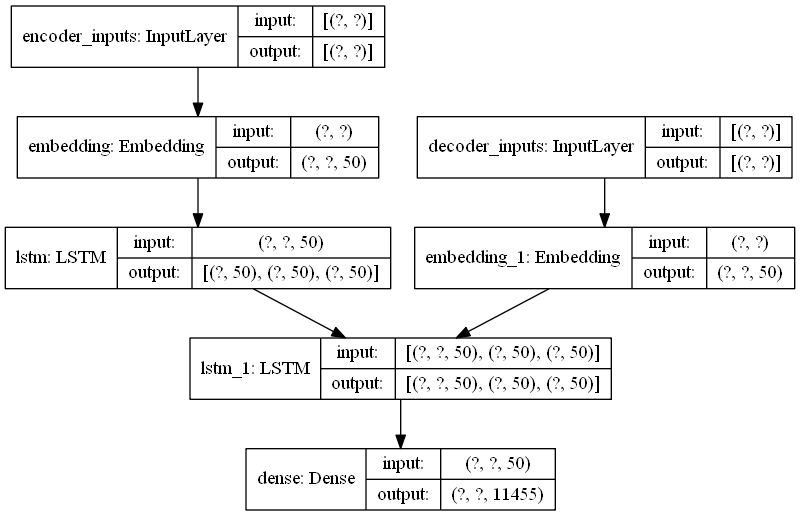

In [40]:
plot_model(model, to_file='train_model.png', show_shapes=True)

In [41]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 5

In [2]:
model.fit_generator(generator = generator_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs)

NameError: name 'model' is not defined

## Saving the model into Json

In [3]:
model_json = model.to_json()
with open("model_2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weight_5.h5")
print("Saved model to disk")

NameError: name 'model' is not defined

## Loading the model and weight from Json

In [71]:
# loading the model architecture and asigning the weights
json_file = open('model_2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json)
# load weights into new model
model_loaded.load_weights("model_weight_5.h5")

# Inference

In [72]:
latent_dim = 50
#inference encoder
encoder_inputs_inf = model_loaded.input[0] #Trained encoder input layer
encoder_outputs_inf, inf_state_h, inf_state_c = model_loaded.layers[4].output # retoring the encoder lstm output and states
encoder_inf_states = [inf_state_h,inf_state_c]
encoder_model = Model(encoder_inputs_inf,encoder_inf_states)

In [73]:
#inference decoder
# The following tensor will store the state of the previous timestep in the "starting the encoder final time step"
decoder_state_h_input = Input(shape=(latent_dim,)) #becase during training we have set the lstm unit to be of 50
decoder_state_c_input = Input(shape=(latent_dim,))
decoder_state_input = [decoder_state_h_input,decoder_state_c_input]

# # inference decoder input
decoder_input_inf = model_loaded.input[1] #Trained decoder input layer
# decoder_input_inf._name='decoder_input'
decoder_emb_inf = model_loaded.layers[3](decoder_input_inf)
decoder_lstm_inf = model_loaded.layers[5]
decoder_output_inf, decoder_state_h_inf, decoder_state_c_inf = decoder_lstm_inf(decoder_emb_inf, initial_state =decoder_state_input)
decoder_state_inf = [decoder_state_h_inf,decoder_state_c_inf]
#inference dense layer
dense_inf = model_loaded.layers[6]
decoder_output_final = dense_inf(decoder_output_inf)# A dense softmax layer to generate prob dist. over the target vocabulary

decoder_model = Model([decoder_input_inf]+decoder_state_input,[decoder_output_final]+decoder_state_inf)



## loading the saved tokenizer for the prediction

In [74]:
with open('tokenizer_input.pkl','rb') as f:
  tokenizer_input = pkl.load(f)
with open('tokenizer_target.pkl','rb') as f:
  tokenizer_target = pkl.load(f)
# Creating the reverse mapping to get the word from the index in the sequence
reverse_word_map_input = dict(map(reversed, tokenizer_input.word_index.items()))
reverse_word_map_target = dict(map(reversed, tokenizer_target.word_index.items()))

## Code for generating the translated sentance

In [75]:
# Code to predct the input sentences translation
def decode_seq(input_seq):
  # print("input_seq=>",input_seq)
  state_values_encoder = encoder_model.predict(input_seq)
  # intialize the target seq with start tag
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tokenizer_target.word_index['start']
  # print("target_seq:=>",target_seq)
  stop_condition = False
  decoder_sentance = ''
  # print("Beforee the while loop")
  while not stop_condition:
    sample_word , decoder_h,decoder_c= decoder_model.predict([target_seq] + state_values_encoder)
    # print("sample_word: =>",sample_word)
    sample_word_index = np.argmax(sample_word[0,-1,:])
    # print("sample_word_index: ",sample_word_index)
    decoder_word = reverse_word_map_target[sample_word_index]
    decoder_sentance += ' '+ decoder_word
    # print("decoded word:=>",decoder_word)
    # print(len(decoder_sentance))
    # print("len(decoder_sentance) > 70: ",len(decoder_sentance) > 70)
    # print('decoder_word == "end"',decoder_word == 'end')
    # print(decoder_word == 'end' or len(decoder_sentance) > 70)
    # stop condition for the while loop
    if (decoder_word == 'end' or 
        len(decoder_sentance) > 70):
        stop_condition = True
        # print("from if condition")
    # target_seq = np.zeros((1,1))
    target_seq[0, 0] = sample_word_index
    # print(target_seq)
    state_values_encoder = [decoder_h,decoder_c]
  return decoder_sentance


## some sentance translation from english sentance

In [76]:
for i in range(100):
  sentance = X_test[i]
  original_target = y_test[i]
  input_seq = tokenizer_input.texts_to_sequences([sentance])
  pad_sequence = pad_sequences(input_seq, maxlen= 30, padding='post')
  # print('input_sequence =>',input_seq)
  # print("pad_seq=>",pad_sequence)
  predicted_target = decode_seq(pad_sequence)
  print("Test sentance: ",i+1)
  print("sentance: ",sentance)
  print("origianl translate:",original_target[6:-4])
  print("predicted Translate:",predicted_target[:-4])
  print("=="*50)


Test sentance:  1
sentance:  why cant you get a job
origianl translate: तुला नोकरी का नाही मिळू शकत
predicted Translate:  ते मेरीला का नाही काम ऑस्ट्रेलियामध्ये
Test sentance:  2
sentance:  do you have a bike
origianl translate: तुमच्याकडे बाईक आहे का
predicted Translate:  ते नाहीये हा
Test sentance:  3
sentance:  this bird cant fly
origianl translate: हा पक्षी उडू शकत नाही
predicted Translate:  त्या जोक नाव
Test sentance:  4
sentance:  who doesnt like christmas
origianl translate: नाताळ कोणाला आवडत नाही
predicted Translate:  नका सफरचंद पुस्तकं होतं
Test sentance:  5
sentance:  tom was kicked off the bus
origianl translate: टॉमला बसमधून बाहेर काढून टाकण्यात आलं
predicted Translate:  टॉम आहात गिटार घेऊन दुरुस्त होता
Test sentance:  6
sentance:  then what did you do
origianl translate: मग काय केलंस तू
predicted Translate:  तुला नाहीये माझं माहीत आहे
Test sentance:  7
sentance:  it is wrong to steal
origianl translate: चोरी करणं चुकीचं असतं
predicted Translate:  म्हणतात बोलता
Test sentanc

predicted Translate:  उद्या कोणीही त्याची तर
Test sentance:  39
sentance:  she became a police officer
origianl translate: त्या पोलीस ऑफिसर बनल्या
predicted Translate:  अभ्यास एक सापडलं खूष अजूनही आहे
Test sentance:  40
sentance:  bring wine
origianl translate: वाईन आणा
predicted Translate:  खरं का
Test sentance:  41
sentance:  tom is looking for something
origianl translate: टॉम काहीतरी शोधतोय
predicted Translate:  टॉम तिने द्या चालू
Test sentance:  42
sentance:  we were happy then
origianl translate: तेव्हा आम्ही खुश होतो
predicted Translate:  आम्ही साफ कॅनेडियन
Test sentance:  43
sentance:  let the boy go
origianl translate: मुलाला सोड
predicted Translate:  त्यांना ट्रेन काहीतरी
Test sentance:  44
sentance:  id be surprised if tom doesnt win
origianl translate: टॉम जिंकला नाही तर मला आश्चर्य होईल
predicted Translate:  टॉमला हात हवी जन्म रंग अमेरिकन माझ्यासाठी
Test sentance:  45
sentance:  youre making a big mistake
origianl translate: तू एक मोठी चूक करतोयस
predicted Translate:  जेवण

sentance:  tom was a manager
origianl translate: टॉम मॅनेजर होता
predicted Translate:  टॉम टॉमकडे तिने आवडला
Test sentance:  82
sentance:  lets get married
origianl translate: लग्न करूया
predicted Translate:  होती बंदूक आवडते
Test sentance:  83
sentance:  he does not take care of his children
origianl translate: तो आपल्या मुलांची काळजी घेत नाही
predicted Translate:  हे आवडत हे नाहीत इंग्रजी माझ्या मला नाहीयेस नाही
Test sentance:  84
sentance:  tom hid the truth from mary
origianl translate: टॉमने सत्य मेरीपासून लपवलं
predicted Translate:  टॉमला कठीण दे होता
Test sentance:  85
sentance:  the price of eggs is going up
origianl translate: अंडींचा भाव वाढतोय
predicted Translate:  मदत टॉमकडे गेलं बंदूक एकमात्र का
Test sentance:  86
sentance:  i want to go talk to tom
origianl translate: मला जाऊन टॉमशी बोलायचं आहे
predicted Translate:  मी टॉमला हो अतिशय आता नकोस
Test sentance:  87
sentance:  i want to talk to your manager
origianl translate: मला तुझ्या मॅनेजरशी बोलायचं आहे
predicted Translat